In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import seaborn as sns

In [3]:
#https://github.com/comet-ml/comet-content/blob/master/home-credit/data/eda-part-1.ipynb
df = pd.read_csv('credit_date_df.csv', index_col=0)

In [4]:
y = df['NP']

In [5]:
df2 = pd.read_csv('hybrid_2045features.csv', index_col=0)

In [8]:
df2.shape

(19030, 2045)

In [10]:
X = df2
Y = y

In [11]:
from sklearn import model_selection
from statistics import mean, stdev
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score,auc,roc_curve
import time

In [12]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_oversample, y_oversample = ros.fit_resample(X, Y)
print(X.shape)
print(X_oversample.shape)

(19030, 2045)
(34610, 2045)


In [13]:
X = X_oversample
Y = y_oversample

In [14]:
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)
row_index = 0
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('XGBoost', XGBClassifier(eval_metric='mlogloss')))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

# Create StratifiedKFold object.    
tic = time.perf_counter()
for name, model in models:
    skfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=skfold, scoring=scoring)
    f1_results = model_selection.cross_val_score(model, X, Y, cv=skfold, scoring='f1')
    recall_results = model_selection.cross_val_score(model, X, Y, cv=skfold, scoring='recall')
    precision_results = model_selection.cross_val_score(model, X, Y, cv=skfold, scoring='precision')
    roc_auc_results = model_selection.cross_val_score(model, X, Y, cv=skfold, scoring='roc_auc')
    MLA_compare.loc[row_index,'MLA used'] = name
    MLA_compare.loc[row_index, 'Test Accuracy'] = round(mean(cv_results), 4)
    MLA_compare.loc[row_index, 'Precision'] = round(mean(precision_results),4)
    MLA_compare.loc[row_index, 'Recall'] = round(mean(recall_results),4)
    MLA_compare.loc[row_index, 'f1'] = mean(f1_results)
    MLA_compare.loc[row_index, 'roc_auc'] = mean(roc_auc_results)
    results.append(cv_results)
    names.append(name)
    # Print the output.
    print('List of possible accuracies for {0} is: {1}'.format(name, cv_results))
    print('List of possible Precision for {0} is: {1}'.format(name, precision_results))
    print('List of possible Recall for {0} is: {1}'.format(name, recall_results))
    print('List of possible F1 score for {0} is: {1}'.format(name, f1_results))
    print('List of possible ROC_AUC for {0} is: {1}'.format(name, roc_auc_results))
    msg = "%s: %f (%f)" % (name, mean(cv_results), cv_results.std())
    print(msg)
    toc = time.perf_counter()
    secs = toc - tic
    print("---Classifier %s use %0.4f seconds ---" %(name, secs))
    row_index+=1
    
MLA_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)    
MLA_compare

List of possible accuracies for Logistic Regression is: [0.79586825 0.79240104 0.78517769 0.79500144 0.78618896]
List of possible Precision for Logistic Regression is: [0.79425287 0.79282407 0.78592121 0.79255014 0.78602368]
List of possible Recall for Logistic Regression is: [0.79861312 0.79167871 0.78387749 0.79919099 0.7864779 ]
List of possible F1 score for Logistic Regression is: [0.79642703 0.79225098 0.78489802 0.79585671 0.78625072]
List of possible ROC_AUC for Logistic Regression is: [0.87643884 0.87244861 0.87208179 0.87823939 0.87116197]
Logistic Regression: 0.790927 (0.004443)
---Classifier Logistic Regression use 312.9895 seconds ---
List of possible accuracies for XGBoost is: [0.97067322 0.96633921 0.96951748 0.97471829 0.96836175]
List of possible Precision for XGBoost is: [0.94459607 0.93763557 0.94277929 0.95211888 0.94072866]
List of possible Recall for XGBoost is: [1.         0.9991332  0.99971107 0.99971107 0.99971107]
List of possible F1 score for XGBoost is: [0.97

,MLA used,Test Accuracy,Precision,Recall,f1,roc_auc
1,XGBoost,0.9699,0.9436,0.9997,0.970797,0.995979
0,Logistic Regression,0.7909,0.7903,0.7920,0.791137,0.874074


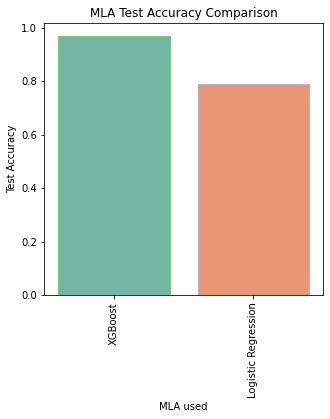

In [15]:
# Creating plot to show the train accuracy
plt.subplots(figsize=(5,5))
sns.barplot(x="MLA used", y="Test Accuracy",data=MLA_compare,palette='Set2',edgecolor=sns.color_palette('Accent',7))
plt.xticks(rotation=90)
plt.title('MLA Test Accuracy Comparison')
plt.show()